# Curve-focus jittered sampling
Apexes-focused sampling(irregular, denser in the apexes, sparser in the flanks)

LSQR & SPGL1 in Fourier domain

sampling ratio: 35/128

In [1]:
import scipy.io
import numpy as np
import pylops
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr
from pylops.optimization.sparsity import *
plt.close('all')

In [2]:
# load the data
mat = scipy.io.loadmat('GulfOfSuez128.mat')
data = mat["D"]
D = data[:, :, 63]
D_sqz = D.reshape(-1,order = 'C')
nt,nr = D.shape
N = nt*nr

Text(0.5, 1.0, 'Original data')

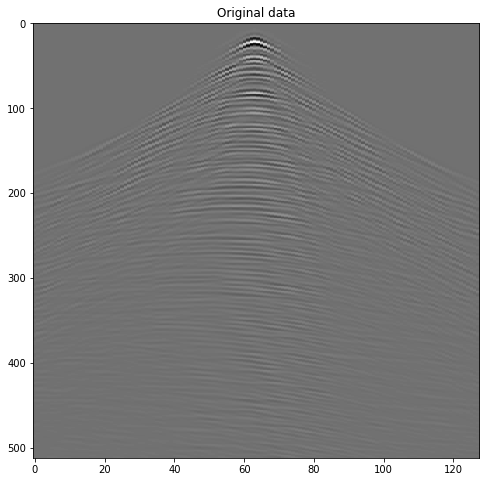

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(D,cmap='gray',aspect='auto')
ax.set_title('Original data')

In [4]:
# frqeuncy spectrum
F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))

# Here cannot use reshape in column-wise, which is different from that of Matlab
fre = F*D.flatten()
D_adjF = F.H*fre

fre = (fre.reshape(nt, nr,order='C')) # undo the scailing
fre_shift = np.fft.fftshift(fre)

fre_np = np.fft.fftshift(np.fft.fft2(D))
fre_np_sqz = fre_np.reshape(-1,order='C')

# Jitterred subsampling

In [5]:
# relocation sampling(curvatural focus)
# focus zone [40 80]
s_min = 40
s_max= 80

interval_d = 2
interval_s = 6
node_s1 = np.arange(0,s_min,interval_s)
node_s2 = np.arange(s_max,nr,interval_s)
node_d = np.arange(s_min,s_max,interval_d)
jitter_s1 = np.random.randint(interval_s,size=node_s1.size)
jitter_s1[-1] = np.random.randint(s_min - node_s1[-1])
jitter_s2 = np.random.randint(interval_s,size=node_s2.size)
jitter_s2[-1] = np.random.randint(nr - node_s2[-1])
jitter_d = np.random.randint(interval_d,size=node_d.size)
jitter_d[-1] = np.random.randint(s_max - node_d[-1])

jitter = np.concatenate((node_s1+jitter_s1,node_d+jitter_d,node_s2+jitter_s2,),axis=None)

cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,jitter].flatten()

R = pylops.Restriction(N, idx)
D_dec = R*D_sqz
D_adj = R.H*D_dec

In [6]:
# print(node)
print(jitter)
print(jitter.size)

[  0  11  16  23  27  31  38  41  42  45  47  49  50  52  55  57  59  60
  62  65  66  68  71  72  74  76  79  80  88  96 103 109 112 119 127]
35


Text(0.5, 1.0, 'Adjoint recovery')

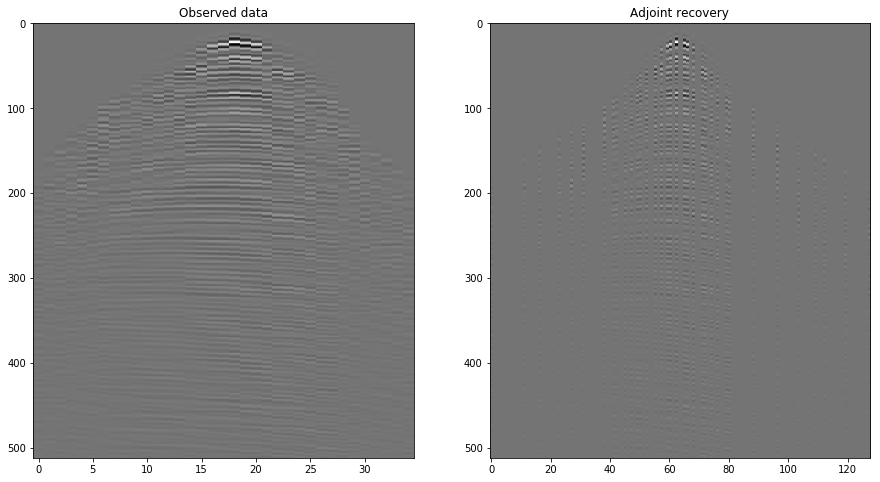

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(D_dec.reshape(nt,jitter.size,order='C'),cmap='gray',aspect='auto')
axs[0].set_title('Observed data')
axs[1].imshow(D_adj.reshape(nt,nr,order='C'),cmap='gray',aspect='auto')
axs[1].set_title('Adjoint recovery')

# Calculating derivatives

In [8]:
# calculate derivatives from original data(with masks and highpass)
# by hand
fre_sqz = F*D.flatten()

dx=10
kn=1/(2*dx)
dk=2*kn/nr
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=5e-3
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre


# Construction & solving of the linear system

In [9]:
# solve the linear equations
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))

# solve in time domain
Forward = pylops.VStack([R*F.H, R*F.H*D1op_hand])
rhs = np.concatenate((D_dec, D1_dec))

Forward2 = pylops.VStack([R*F.H, R*F.H*D1op_hand, R*F.H*D2op_hand])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)


In [10]:
xinv = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward2, [], rhs2, 
                                                          **dict(damp=0, atol=1e-9 ,btol=1e-9, show=1,iter_lim=200))

sigma = np.linalg.norm(rhs2 - (Forward2*xinv)) # same as r2norm from lsqr result, but the problem is what is its convergence condition?
r1norm = np.linalg.norm(rhs2 - (Forward2*xinv),ord=0)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    53760 rows  and    65536 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-09                 conlim = 1.00e+08
btol = 1.00e-09               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.258e+03  3.258e+03    1.0e+00  3.1e-04
     1  1.30868e+00   3.992e+02  3.992e+02    1.2e-01  1.8e-01   1.0e+00  1.0e+00
     2  1.36550e+00   3.641e+02  3.641e+02    1.1e-01  3.3e-01   1.1e+00  2.7e+00
     3  1.62759e+00   2.336e+02  2.336e+02    7.2e-02  7.3e-02   1.4e+00  7.3e+00
     4  1.64875e+00   2.299e+02  2.299e+02    7.1e-02  8.9e-02   1.6e+00  8.7e+00
     5  1.73037e+00   2.128e+02  2.128e+02    6.5e-02  2.5e-02   1.8e+00  1.4e+01
     6  1.73147e+00   2.125e+02  2.125e+02    6.5e-02  1.6e-02   2.0e+00  1.6e+01
     7  1.74565e+00   2.115e+02  2.115e+02    6.5e-02  1.3e-02   2.1e+00  2.0e+01
     8  1.74807e+00   2.113e

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/basicoperators/Restriction.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iava] = x
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/lsqr.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


    10  1.75771e+00   2.111e+02  2.111e+02    6.5e-02  4.9e-03   2.6e+00  3.1e+01
   190  1.82987e+00   2.107e+02  2.107e+02    6.5e-02  3.6e-05   2.0e+02  2.2e+04
   191  1.82996e+00   2.107e+02  2.107e+02    6.5e-02  3.5e-05   2.0e+02  2.2e+04
   192  1.83006e+00   2.107e+02  2.107e+02    6.5e-02  3.5e-05   2.0e+02  2.2e+04
   193  1.83015e+00   2.107e+02  2.107e+02    6.5e-02  3.5e-05   2.0e+02  2.3e+04
   194  1.83024e+00   2.107e+02  2.107e+02    6.5e-02  3.5e-05   2.0e+02  2.3e+04
   195  1.83033e+00   2.107e+02  2.107e+02    6.5e-02  3.4e-05   2.1e+02  2.3e+04
   196  1.83042e+00   2.107e+02  2.107e+02    6.5e-02  3.4e-05   2.1e+02  2.3e+04
   197  1.83052e+00   2.107e+02  2.107e+02    6.5e-02  3.4e-05   2.1e+02  2.4e+04
   198  1.83061e+00   2.107e+02  2.107e+02    6.5e-02  3.3e-05   2.1e+02  2.4e+04
   199  1.83070e+00   2.107e+02  2.107e+02    6.5e-02  3.3e-05   2.1e+02  2.4e+04
   200  1.83079e+00   2.107e+02  2.107e+02    6.5e-02  3.3e-05   2.1e+02  2.4e+04
 
LSQR finished


In [11]:
xinv2, pspgl2, info2 = SPGL1(Forward2, rhs2,sigma=sigma,returninfo=True, 
                             **dict(iterations=400))

sigma2 = np.linalg.norm(rhs2 - (Forward2*xinv2))
r1norm2 = np.linalg.norm(rhs2 - (Forward2*xinv2),ord=0)


In [13]:
xinv = np.real(F.H*xinv).reshape(nt,nr)
xinv2 = np.real(F.H*xinv2).reshape(nt,nr)

xinv_fre = np.fft.fftshift(np.fft.fft2(xinv))
xinv2_fre = np.fft.fftshift(np.fft.fft2(xinv2))

relative = np.abs((xinv - D) / np.amax(D))
relative2 = np.abs((xinv2 - D) / np.amax(D))

relative_fre = np.abs((xinv_fre - fre_np) / np.amax(fre_np))
relative2_fre = np.abs((xinv2_fre - fre_np) / np.amax(fre_np))


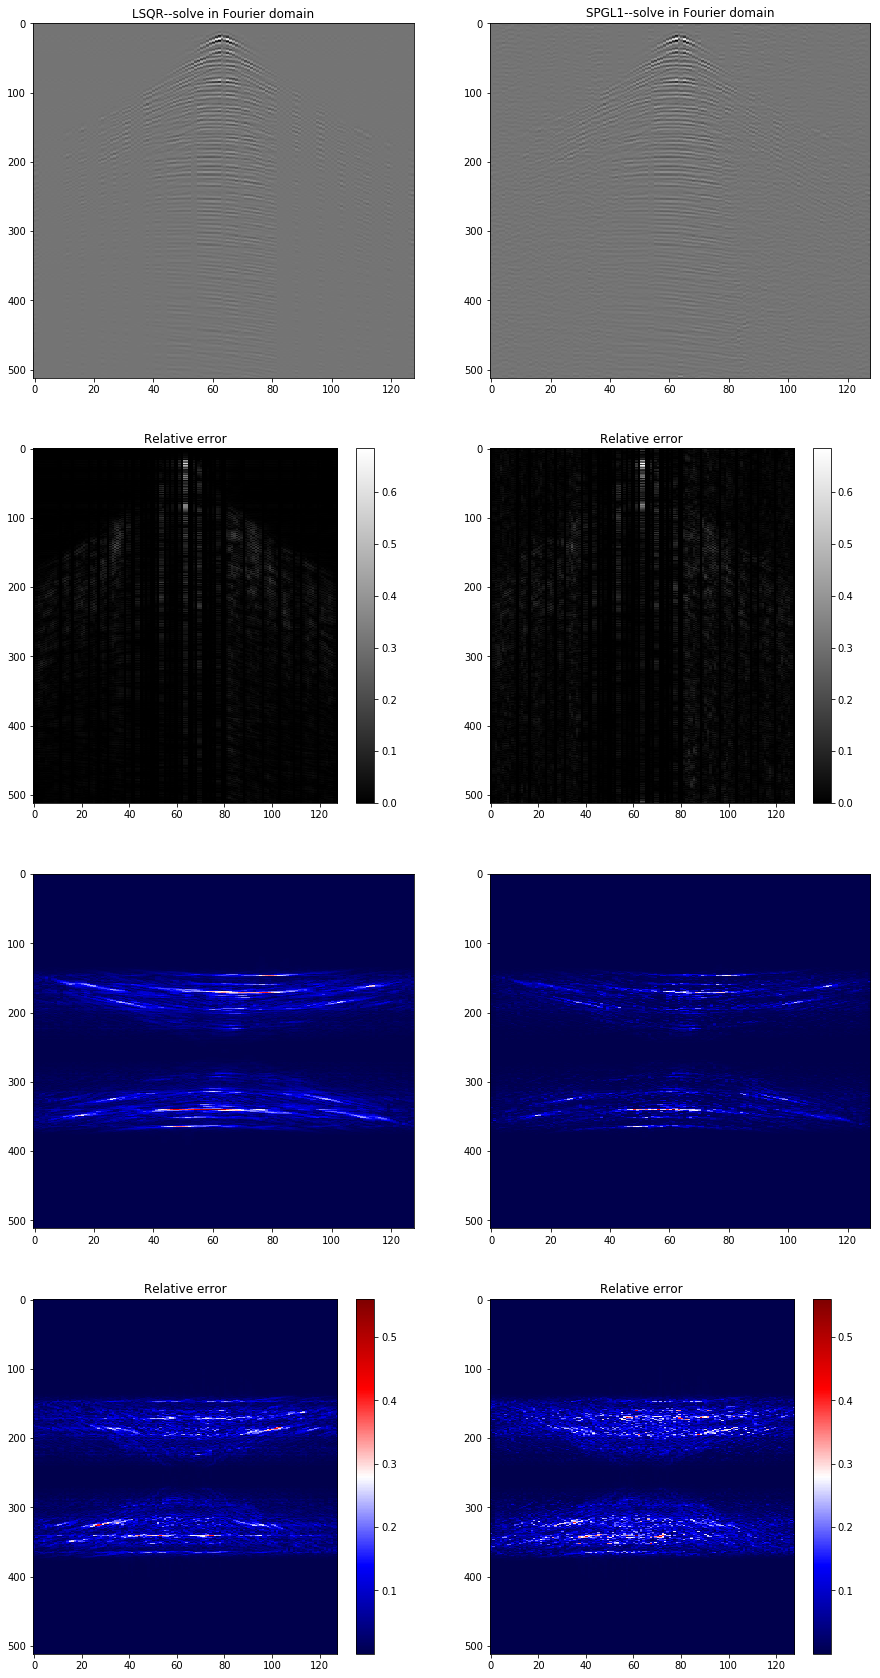

In [14]:
combined_data = np.array([relative,relative2])
t_min, t_max = np.amin(combined_data), np.amax(combined_data)

combined_data = np.array([relative_fre,relative2_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs[0,0].imshow(np.real(xinv),cmap='gray',aspect='auto')
axs[0,0].set_title('LSQR--solve in Fourier domain')
axs[0,1].imshow(np.real(xinv2),cmap='gray',aspect='auto')
axs[0,1].set_title('SPGL1--solve in Fourier domain')
im1 = axs[1,0].imshow(relative,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[1,1].imshow(relative2,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[1,0])
fig.colorbar(im2,ax=axs[1,1])
axs[1,0].set_title('Relative error')
axs[1,1].set_title('Relative error')
axs[2,0].imshow(np.abs(xinv_fre),cmap='seismic',aspect='auto')
axs[2,1].imshow(np.abs(xinv2_fre),cmap='seismic',aspect='auto')
im3 = axs[3,0].imshow(relative_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
im4 = axs[3,1].imshow(relative2_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
axs[3,0].set_title('Relative error')
axs[3,1].set_title('Relative error')
fig.colorbar(im3,ax=axs[3,0])
fig.colorbar(im4,ax=axs[3,1])